In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import gc
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, GroupKFold

In [2]:
test  = pd.read_csv('test.csv')
labels = pd.read_csv('train_labels.csv')

In [3]:
# READ USER ID ONLY
tmp = pd.read_csv('train.csv',usecols=[0])
tmp = tmp.groupby('session_id').session_id.agg('count')

# COMPUTE READS AND SKIPS
PIECES = 12
CHUNK = int( np.ceil(len(tmp)/PIECES) )

reads = []
skips = [0]
for k in range(PIECES):
    a = k*CHUNK
    b = (k+1)*CHUNK
    if b>len(tmp): b=len(tmp)
    r = tmp.iloc[a:b].sum()
    reads.append(r)
    skips.append(skips[-1]+r)
    
print(f'To avoid memory error, we will read train in {PIECES} pieces of sizes:')
print(reads)

To avoid memory error, we will read train in 12 pieces of sizes:
[2208580, 2238585, 2181336, 2209139, 2203924, 2213922, 2188184, 2177814, 2160779, 2188720, 2166242, 2159721]


In [4]:
# reset index, split session_id
#=========================================================================
labels['session'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )
labels['q_answered'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print( labels.shape )
labels.head()


(424116, 4)


,session_id,correct,session,q_answered
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


In [5]:
# define typed lists
#=========================================================================
# For Engineering
categories = ['event_name', 'fqid', 'room_fqid', 'text']

events = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','map_click','observation_click',
          'checkpoint']

# For retaining features
numbers = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

#=========================================================================
# create engineered dataframe
#=========================================================================
def feature_engineer(train):
    # Create list of new dfs to later merge together
    eng_df = []

    # We don't really need the exact data for these columns
    for cat in categories:
        temp = train.groupby(['session_id','level_group'])[cat].agg('nunique')
        temp.name = temp.name + '_nunique'
        eng_df.append(temp)

    # Simplify events data
    for step in events:
        train[step] = (train.event_name == step).astype('int8')
    for step in events + ['elapsed_time']:
        temp = train.groupby(['session_id','level_group'])[step].agg('sum')
        temp.name = temp.name + '_sum'
        eng_df.append(temp)

    # Keep numerical data
    for step in numbers:
        temp = train.groupby(['session_id','level_group'])[step].agg('sum')
        eng_df.append(temp)

    # Drop 
    train = train.drop(events,axis=1)

    df = pd.concat(eng_df,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [7]:
%%time

# PROCESS TRAIN DATA IN PIECES
all_pieces = []
print(f'Processing train as {PIECES} pieces to avoid memory error... ')
for k in range(PIECES):
    print(k,', ',end='')
    SKIPS = 0
    if k>0: SKIPS = range(1,skips[k]+1)
    train = pd.read_csv('train.csv',
                        nrows=reads[k], skiprows=SKIPS)
    df = feature_engineer(train)
    all_pieces.append(df)
    
# CONCATENATE ALL PIECES
print('\n')
del train; gc.collect()
df = pd.concat(all_pieces, axis=0)
print('Shape of all train data after feature engineering:', df.shape )
df.head()


Processing train as 12 pieces to avoid memory error... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 

Shape of all train data after feature engineering: (70686, 23)
CPU times: total: 7min 25s
Wall time: 11min 19s


,level_group,event_name_nunique,fqid_nunique,room_fqid_nunique,text_nunique,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum,elapsed_time_sum,elapsed_time,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration
session_id,,,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,30,7,56,81,22,28,11,4,8,2,4,1,14155937,14155937,321,0.0,1201.398834,-11140.544849,69952.0,59755.0,19116.0
20090312431273200,13-22,10,49,12,168,170,123,60,20,14,10,6,3,1,437052322,437052322,7309,0.0,-51096.090454,-63505.689523,173456.0,148686.0,24298.0
20090312431273200,5-12,10,39,11,124,103,104,12,28,9,9,8,1,1,105732736,105732736,2384,0.0,3791.106501,-15176.370454,119767.0,100378.0,29080.0
20090312433251036,0-4,11,22,6,49,49,18,36,15,3,5,3,2,1,13571045,13571045,260,0.0,-10925.974736,-6977.240641,46569.0,48194.0,11030.0
20090312433251036,13-22,11,73,16,183,637,145,65,83,186,14,45,5,1,3241011333,3241011333,23038,255.0,-32115.822788,-149147.814734,483218.0,404999.0,181537.0


In [8]:
labels = labels.reset_index()
print(f"Length = {len(labels)}")
labels = labels.drop("index", axis=1)
labels.head()


Length = 424116


,session_id,correct,session,q_answered
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


In [9]:
features = [c for c in df.columns if c != 'level_group']
print(len(features))
user_list = df.index.unique()
print(len(user_list))

22
23562


In [11]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(user_list),18)), index=user_list)
models = {}

# CV score with 5 group kfold
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('Fold',i+1)
    
    xgb_params = {
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
    'learning_rate': 0.05,
    'max_depth': 4,
    'n_estimators': 1000,
    'early_stopping_rounds': 50,
    'tree_method':'hist',
    'subsample':0.8,
    'colsample_bytree': 0.4}
    
    # Iterate through questions in labels df
    for t in range(1,19):
        
        # Use this to train data based on groupings that match training set
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = labels.loc[labels.q_answered==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = labels.loc[labels.q_answered==t].set_index('session').loc[valid_users]
        
        # Train Model        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[features].astype('float32'), train_y['correct'],
                eval_set=[ (valid_x[features].astype('float32'), valid_y['correct']) ],
                verbose=0)
        print(f'{t}({clf.best_ntree_limit}), ',end='')
        
        # Save model, predict valid OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[features].astype('float32'))[:,1]
        
    print()

Fold 1
1(202), 2(102), 3(132), 4(256), 5(115), 6(96), 7(108), 8(125), 9(176), 10(133), 11(105), 12(106), 13(150), 14(232), 15(219), 16(63), 17(62), 18(179), 
Fold 2
1(168), 2(266), 3(129), 4(126), 5(126), 6(138), 7(90), 8(103), 9(130), 10(108), 11(152), 12(157), 13(150), 14(237), 15(195), 16(126), 17(100), 18(106), 
Fold 3
1(150), 2(172), 3(118), 4(182), 5(114), 6(96), 7(96), 8(71), 9(96), 10(117), 11(95), 12(74), 13(85), 14(200), 15(236), 16(136), 17(121), 18(192), 
Fold 4
1(180), 2(156), 3(95), 4(200), 5(158), 6(84), 7(132), 8(98), 9(110), 10(104), 11(80), 12(124), 13(163), 14(188), 15(190), 16(102), 17(72), 18(186), 
Fold 5
1(176), 2(145), 3(201), 4(214), 5(112), 6(80), 7(96), 8(104), 9(144), 10(98), 11(92), 12(103), 13(207), 14(186), 15(150), 16(69), 17(124), 18(215), 


In [12]:
# Create DF with 18 columns
true = oof.copy()
for k in range(18):
    tmp = labels.loc[labels.q_answered == k+1].set_index('session').loc[user_list]
    true[k] = tmp.correct.values


In [13]:
# Determine best threshold for converting probabilities into 1s and 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.50,0.78,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 

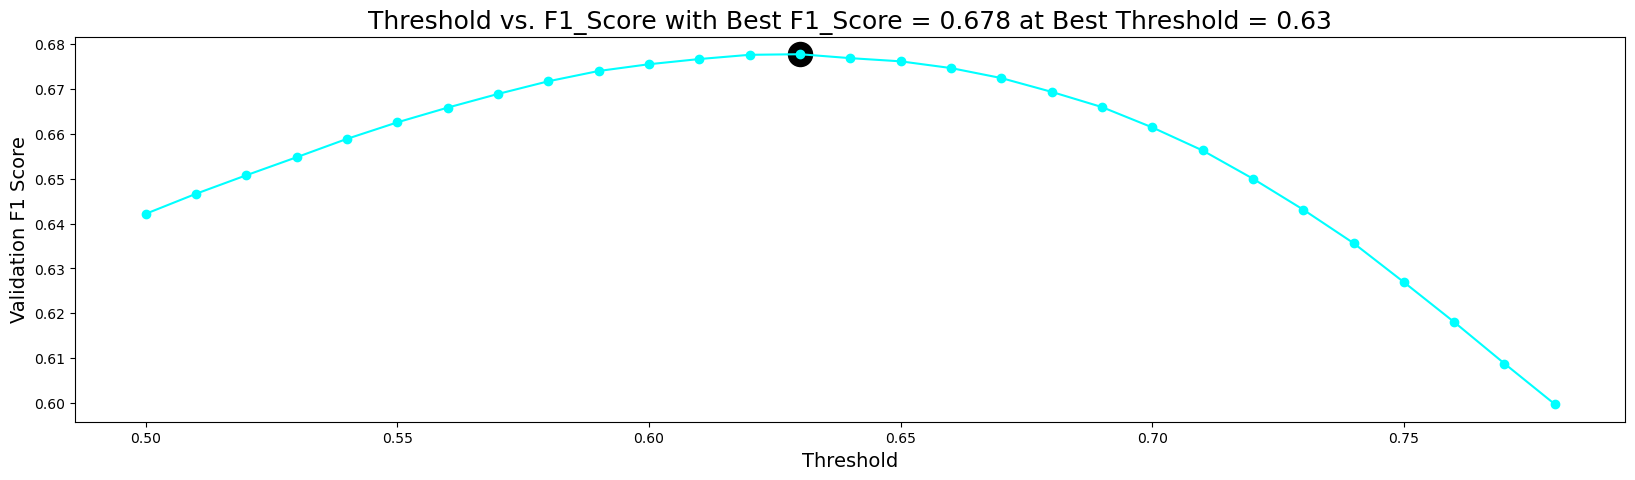

In [14]:
# Plot
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='cyan')
plt.scatter([best_threshold], [best_score], color='black', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [15]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.5976856618187677
Q1: F1 = 0.49463795470144134
Q2: F1 = 0.4897317659147754
Q3: F1 = 0.6147441781982588
Q4: F1 = 0.573136936037421
Q5: F1 = 0.6086754236910288
Q6: F1 = 0.5830327878401889
Q7: F1 = 0.5392389071673968
Q8: F1 = 0.5987424138368078
Q9: F1 = 0.5131986466457262
Q10: F1 = 0.5883429339195725
Q11: F1 = 0.4964356619935303
Q12: F1 = 0.43714295554512006
Q13: F1 = 0.6080055457581575
Q14: F1 = 0.5093120214924896
Q15: F1 = 0.46572944193966676
Q16: F1 = 0.5310748789689391
Q17: F1 = 0.49414589223623184
==> Overall F1 = 0.6777948306124351


In [16]:
true.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
session_id,,,,,,,,,,,,,,,,,,
20090312431273200,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1
20090312433251036,0,1,1,1,0,1,1,0,1,0,0,1,0,1,0,1,0,1
20090312455206810,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1
20090313091715820,0,1,1,1,1,0,1,1,1,0,0,1,0,1,0,1,1,1
20090313571836404,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1
